In [1]:
from sklearn.datasets import load_boston
boston = load_boston()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


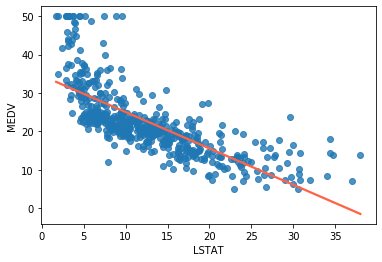

In [122]:
sns.regplot(x='LSTAT', y="MEDV",data=df,ci=None,line_kws={'color':'tomato'});

In [74]:
model = LinearRegression()

In [123]:
X = df['LSTAT'].values.reshape(-1, 1)
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [124]:
model.fit(X_train,y_train)
print('MSE',mean_squared_error(y_test,model.predict(X_test)))
print('R2',r2_score(y_test,model.predict(X_test)))

MSE 39.81715050474417
R2 0.5218049526125568


Взглянем на распределение остатков

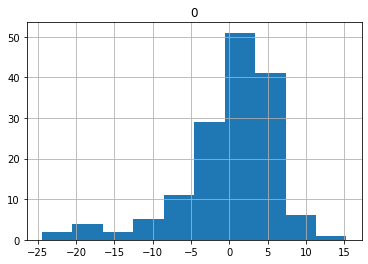

In [125]:
pd.DataFrame(model.predict(X_test) - y_test).hist();

Проверим распределение на нормальность с помощью критерия Шапиро-Уилка

In [126]:
stats.shapiro(model.predict(X_test) - y_test)

(0.8835410475730896, 1.4357476318949125e-09)

Результат показывает нам, что остатки распределены не нормально.

Воспользуемся преобразованием Тьюки

подберем значение lambda для трансформации Тьюки

max_corr 0.8222045154603784
lambda -0.40000000000001634


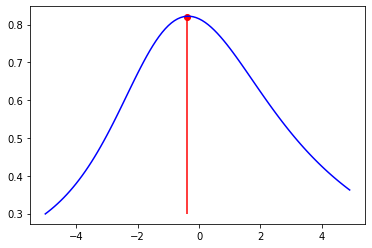

In [127]:
corr_list = {}
for lambda_tukey in np.arange(-5,5,0.1):
    x = df['LSTAT']**lambda_tukey
    corr_list[lambda_tukey] = x.corr(df['MEDV'])
for key,value in corr_list.items():
    corr_list[key] = abs(value)
max_corr = max(corr_list.values())
print('max_corr',max_corr)
for lambda_val, cor in corr_list.items(): 
    if cor == max(corr_list.values()):
        best_lambda = lambda_val
        print('lambda',best_lambda)
plt.plot(-0.4,0.82,marker='o',color = 'r')
plt.vlines(-0.4,0.3,0.82,color = 'r')
sns.lineplot(list(corr_list.keys()),list(corr_list.values()),color='b');

посмотрим графическое представление взаимосвязи

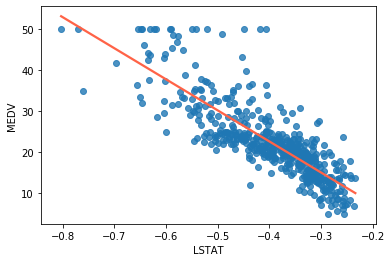

In [146]:
x = -df['LSTAT']**best_lambda
sns.regplot(x, df["MEDV"], data=df,ci=None,line_kws={'color':'tomato'});

In [147]:
X = -(df['LSTAT']**best_lambda).values.reshape(-1, 1)
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [148]:
model.fit(X_train,y_train)
print('MSE',mean_squared_error(y_test,model.predict(X_test)))
print('R2',r2_score(y_test,model.predict(X_test)))

MSE 29.471083649020603
R2 0.6460588951380748


Взглянем на распределение остатков

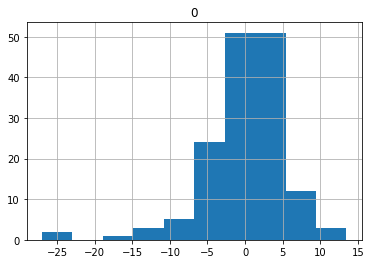

In [149]:
pd.DataFrame(model.predict(X_test) - y_test).hist();

Проверим распределение на нормальность с помощью критерия Шапиро-Уилка

In [150]:
stats.shapiro(model.predict(X_test) - y_test)

(0.8829110860824585, 1.332388421815267e-09)

Результат показывает нам, что остатки распределены не нормально.

Однако в таком подходе есть недостаток-трудность интерпретирования взаимосвязи между переменными.  
Попоробуем логарифмическую трансформацию, с ее помощью возможно интерпретировать полученный результат

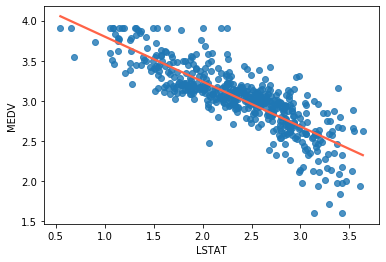

In [152]:
x = np.log(df['LSTAT'])
sns.regplot(x, np.log(df["MEDV"]), data=df,ci=None,line_kws={'color':'tomato'});

In [156]:
X = np.log(df['LSTAT'].values).reshape(-1, 1)
y = np.log(df['MEDV'].values)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [157]:
model.fit(X_train,y_train)
print('MSE',mean_squared_error(y_test,model.predict(X_test)))
print('R2',r2_score(y_test,model.predict(X_test)))

MSE 0.06032145740498631
R2 0.653326518261267


In [158]:
model.coef_[0]

-0.5509513298888452

Данный коэфициент показывает нам следующее - при единичном изменении LSTAT на 1%, MEDV уменьшится на 0.55 %

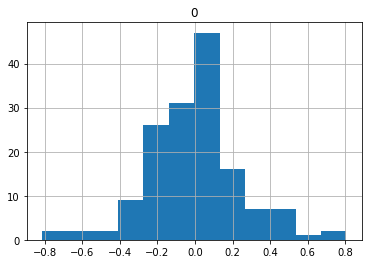

In [168]:
pd.DataFrame(model.predict(X_test) - y_test).hist(bins=12);

In [121]:
stats.shapiro(model.predict(X_test) - y_test)

(0.8842166066169739, 1.5559578070423186e-09)

Объединим 2 метода трансофрмации признаков. Для LSTAT выполним логарифмическое преобразование, а для MEDV степенное

max_corr 0.8071091912752258
lambda -0.20000000000001705


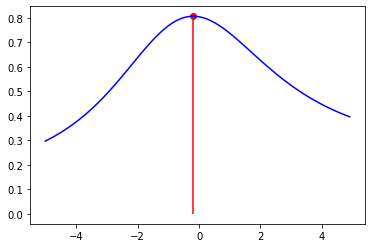

In [186]:
corr_list = {}
for lambda_tukey in np.arange(-5,5,0.1):
    x = df['MEDV']**lambda_tukey
    corr_list[lambda_tukey] = x.corr(df['LSTAT'])
for key,value in corr_list.items():
    corr_list[key] = abs(value)
max_corr = max(corr_list.values())
print('max_corr',max_corr)
for lambda_val, cor in corr_list.items(): 
    if cor == max(corr_list.values()):
        best_lambda = lambda_val
        print('lambda',best_lambda)
plt.plot(best_lambda,max_corr,marker='o',color = 'r')
plt.vlines(best_lambda,0,max_corr,color = 'r')
sns.lineplot(list(corr_list.keys()),list(corr_list.values()),color='b');

In [196]:
X = np.log(df['LSTAT'].values).reshape(-1, 1)
y = -(df['MEDV']**best_lambda).values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [197]:
model.fit(X_train,y_train)
print('MSE',mean_squared_error(y_test,model.predict(X_test)))
print('R2',r2_score(y_test,model.predict(X_test)))

MSE 0.000791710979965188
R2 0.6369517333200003


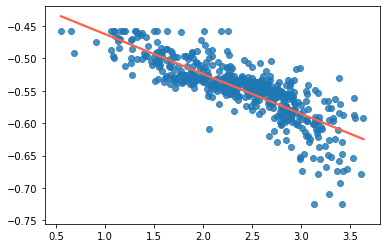

In [198]:
sns.regplot(X, y, data=df,ci=None,line_kws={'color':'tomato'});

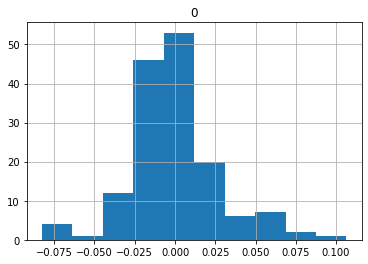

In [199]:
pd.DataFrame(model.predict(X_test) - y_test).hist();

In [200]:
stats.shapiro(model.predict(X_test) - y_test)

(0.9498046040534973, 2.7951266019954346e-05)